In [5]:
!pip install imblearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
import seaborn as sns
from sklearn.model_selection import train_test_split,StratifiedKFold

In [6]:
# load data
data = pd.read_csv("Daily Flood data.csv",usecols=['elevation','OneDayPriorRainfallOrigin',
                            'TenDayPriorOrigin', 'OneDayPriorRainfall', 'threedaysprior',
                            'sevendaysprior', 'tendaysprior', 'Flood'])
print(data.shape)
print(data.head())
#five_rows = data.iloc[10000:10006] 
#print(five_rows)
print(data.describe())

(46046, 8)
   elevation  OneDayPriorRainfallOrigin  TenDayPriorOrigin  \
0        0.0                        0.3               92.3   
1        0.0                        8.3               95.4   
2        0.0                       17.0               96.9   
3        0.0                        4.0               97.8   
4        0.0                        5.3              115.7   

   OneDayPriorRainfall  threedaysprior  sevendaysprior  tendaysprior  Flood  
0                  0.0             0.0            37.0          80.0      0  
1                  0.0             0.0            52.0          80.0      0  
2                  0.0            12.0            72.0          92.0      0  
3                  0.0             0.0            80.0         100.0      0  
4                 12.0            37.0            80.0         115.0      0  
          elevation  OneDayPriorRainfallOrigin  TenDayPriorOrigin  \
count  46046.000000               45895.000000       46046.000000   
mean      

In [7]:
#missing values
null_values = data.isnull().sum()
print(null_values)

#missingvaluesImputation
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=['elevation','OneDayPriorRainfallOrigin',
                            'TenDayPriorOrigin', 'OneDayPriorRainfall', 'threedaysprior',
                            'sevendaysprior', 'tendaysprior', 'Flood'])
imputer = KNNImputer(n_neighbors=5)
data = pd.DataFrame(imputer.fit_transform(data), columns=['elevation','OneDayPriorRainfallOrigin',
                            'TenDayPriorOrigin', 'OneDayPriorRainfall', 'threedaysprior',
                            'sevendaysprior', 'tendaysprior', 'Flood'])
print(data.select_dtypes(include='number').nunique())
print(data.isnull().sum())
print(data.describe())

elevation                      0
OneDayPriorRainfallOrigin    151
TenDayPriorOrigin              0
OneDayPriorRainfall          571
threedaysprior                 0
sevendaysprior                 0
tendaysprior                   0
Flood                          0
dtype: int64
elevation                       5
OneDayPriorRainfallOrigin     887
TenDayPriorOrigin            2150
OneDayPriorRainfall          9359
threedaysprior               2502
sevendaysprior               3030
tendaysprior                 3778
Flood                           2
dtype: int64
elevation                    0
OneDayPriorRainfallOrigin    0
TenDayPriorOrigin            0
OneDayPriorRainfall          0
threedaysprior               0
sevendaysprior               0
tendaysprior                 0
Flood                        0
dtype: int64
          elevation  OneDayPriorRainfallOrigin  TenDayPriorOrigin  \
count  46046.000000               46046.000000       46046.000000   
mean       0.393716                   0

(45070, 10)


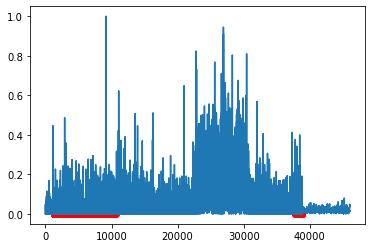

In [8]:
#movingaveragebasedoutlierremoval
# set window size
window_size = 7

# calculate moving average
data['moving_average'] = data['OneDayPriorRainfall'].rolling(window_size).mean()

# calculate z-score for each data point
data['z_score'] = (data['OneDayPriorRainfall'] - data['moving_average']) / data['OneDayPriorRainfall'].rolling(window_size).std()

# identify outliers
threshold = 3
outliers = data[data['z_score'].abs() > threshold]

data = data.drop(outliers.index)
print(data.shape)
# plot data and outliers
plt.plot(data['OneDayPriorRainfall'])
plt.scatter(outliers.index, outliers['OneDayPriorRainfall'], color='r')
plt.show()


(44437, 10)


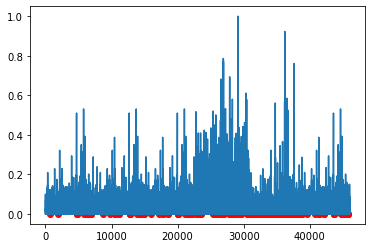

In [9]:
# calculate moving average
data['moving_average'] = data['OneDayPriorRainfallOrigin'].rolling(window_size).mean()

# calculate z-score for each data point
data['z_score'] = (data['OneDayPriorRainfallOrigin'] - data['moving_average']) / data['OneDayPriorRainfallOrigin'].rolling(window_size).std()

# identify outliers
threshold = 3
outliers = data[data['z_score'].abs() > threshold]

data = data.drop(outliers.index)
print(data.shape)
# plot data and outliers
plt.plot(data['OneDayPriorRainfallOrigin'])
plt.scatter(outliers.index, outliers['OneDayPriorRainfallOrigin'], color='r')
plt.show()

In [10]:
#imbalanceclasshanding
from imblearn.over_sampling import SMOTE
print(data.columns)
data = data.drop(['moving_average', 'z_score'], axis=1)
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_resample(data.drop('Flood', axis=1), data['Flood'])
oversampled = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)
X_train, X_test, y_train, y_test = train_test_split(oversampled_X, oversampled_Y, test_size=0.3, random_state=32)

Index(['elevation', 'OneDayPriorRainfallOrigin', 'TenDayPriorOrigin',
       'OneDayPriorRainfall', 'threedaysprior', 'sevendaysprior',
       'tendaysprior', 'Flood', 'moving_average', 'z_score'],
      dtype='object')


In [11]:
!pip install mlxtend

In [12]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.svm import SVC
from mlxtend.feature_selection import SequentialFeatureSelector

scv = StratifiedKFold(n_splits=5)
feature_selector = SequentialFeatureSelector(RandomForestClassifier(n_jobs=-1),
                                             k_features=6,
                                             forward=False,
                                             verbose=2,
                                             scoring='roc_auc',
                                             cv=scv)
features = feature_selector.fit(np.array(X_train.fillna(0)), y_train)

filtered_features = X_train.columns[list(features.k_feature_idx_)]
print(filtered_features)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.4s remaining:    0.0s


Index(['elevation', 'OneDayPriorRainfallOrigin', 'TenDayPriorOrigin',
       'OneDayPriorRainfall', 'threedaysprior', 'sevendaysprior'],
      dtype='object')


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  3.8min finished

[2023-03-08 17:18:33] Features: 6/6 -- score: 0.9994682293548905

In [21]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, classification_report

data= oversampled.drop(['tendaysprior'], axis=1)
x=data.drop('Flood', axis=1)
y=data['Flood']
X_train_full, X_test, y_train_full, y_test = train_test_split(x, y, test_size=0.3,
                                                              random_state=1)
clf = BaggingClassifier(n_estimators=16, random_state=22)
clf.fit(X_train_full, y_train_full)
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     12488
         1.0       0.98      1.00      0.99     12417

    accuracy                           0.99     24905
   macro avg       0.99      0.99      0.99     24905
weighted avg       0.99      0.99      0.99     24905



elevation                      0
OneDayPriorRainfallOrigin    151
TenDayPriorOrigin              0
OneDayPriorRainfall          571
threedaysprior                 0
sevendaysprior                 0
tendaysprior                   0
Flood                          0
dtype: int64
elevation                       5
OneDayPriorRainfallOrigin     887
TenDayPriorOrigin            2150
OneDayPriorRainfall          9359
threedaysprior               2502
sevendaysprior               3030
tendaysprior                 3778
Flood                           2
dtype: int64
elevation                    0
OneDayPriorRainfallOrigin    0
TenDayPriorOrigin            0
OneDayPriorRainfall          0
threedaysprior               0
sevendaysprior               0
tendaysprior                 0
Flood                        0
dtype: int64
          elevation  OneDayPriorRainfallOrigin  TenDayPriorOrigin  \
count  46046.000000               46046.000000       46046.000000   
mean       0.393716                   0

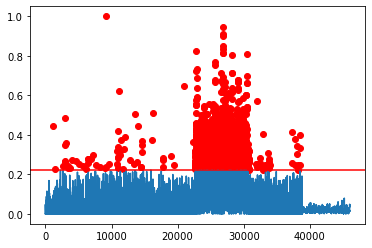

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load data
data = pd.read_csv("Daily Flood data.csv",usecols=['elevation','OneDayPriorRainfallOrigin',
                            'TenDayPriorOrigin', 'OneDayPriorRainfall', 'threedaysprior',
                            'sevendaysprior', 'tendaysprior', 'Flood'])

#missing values
null_values = data.isnull().sum()
print(null_values)

#missingvaluesImputation
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=['elevation','OneDayPriorRainfallOrigin',
                            'TenDayPriorOrigin', 'OneDayPriorRainfall', 'threedaysprior',
                            'sevendaysprior', 'tendaysprior', 'Flood'])
imputer = KNNImputer(n_neighbors=5)
data = pd.DataFrame(imputer.fit_transform(data), columns=['elevation','OneDayPriorRainfallOrigin',
                            'TenDayPriorOrigin', 'OneDayPriorRainfall', 'threedaysprior',
                            'sevendaysprior', 'tendaysprior', 'Flood'])
print(data.select_dtypes(include='number').nunique())
print(data.isnull().sum())
print(data.describe())

# set percentile threshold
threshold = 95

# calculate percentile
percentile = np.percentile(data['OneDayPriorRainfall'], threshold)

# identify outliers
outliers = data[data['OneDayPriorRainfall'] > percentile]

data = data.drop(outliers.index)
print(data.shape)
# plot data and outliers
plt.plot(data['OneDayPriorRainfall'])
plt.axhline(percentile, color='r')
plt.scatter(outliers.index, outliers['OneDayPriorRainfall'], color='r')
plt.show()

(39540, 8)


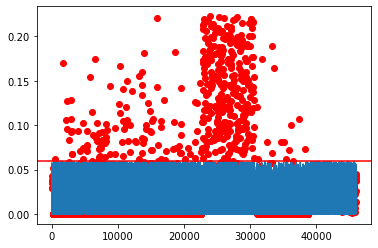

In [24]:
# set percentile threshold
threshold = 95

# calculate percentile
percentile = np.percentile(data['OneDayPriorRainfallOrigin'], threshold)

# identify outliers
outliers = data[data['OneDayPriorRainfallOrigin'] > percentile]

data = data.drop(outliers.index)
print(data.shape)
# plot data and outliers
plt.plot(data['OneDayPriorRainfallOrigin'])
plt.axhline(percentile, color='r')
plt.scatter(outliers.index, outliers['OneDayPriorRainfall'], color='r')
plt.show()

In [25]:
#imbalanceclasshanding
from imblearn.over_sampling import SMOTE
print(data.columns)
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_resample(data.drop('Flood', axis=1), data['Flood'])
oversampled = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)
X_train, X_test, y_train, y_test = train_test_split(oversampled_X, oversampled_Y, test_size=0.3, random_state=32)

Index(['elevation', 'OneDayPriorRainfallOrigin', 'TenDayPriorOrigin',
       'OneDayPriorRainfall', 'threedaysprior', 'sevendaysprior',
       'tendaysprior', 'Flood'],
      dtype='object')


In [26]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.svm import SVC
from mlxtend.feature_selection import SequentialFeatureSelector

scv = StratifiedKFold(n_splits=5)
feature_selector = SequentialFeatureSelector(RandomForestClassifier(n_jobs=-1),
                                             k_features=6,
                                             forward=False,
                                             verbose=2,
                                             scoring='roc_auc',
                                             cv=scv)
features = feature_selector.fit(np.array(X_train.fillna(0)), y_train)

filtered_features = X_train.columns[list(features.k_feature_idx_)]
print(filtered_features)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.9s remaining:    0.0s


Index(['elevation', 'OneDayPriorRainfallOrigin', 'TenDayPriorOrigin',
       'threedaysprior', 'sevendaysprior', 'tendaysprior'],
      dtype='object')


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  3.1min finished

[2023-03-08 17:26:57] Features: 6/6 -- score: 0.9996895215769891

In [27]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, classification_report

data= oversampled.drop(['OneDayPriorRainfall'], axis=1)
x=data.drop('Flood', axis=1)
y=data['Flood']
X_train_full, X_test, y_train_full, y_test = train_test_split(x, y, test_size=0.3,
                                                              random_state=1)
clf = BaggingClassifier(n_estimators=16, random_state=22)
clf.fit(X_train_full, y_train_full)
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     11890
         1.0       0.98      1.00      0.99     11789

    accuracy                           0.99     23679
   macro avg       0.99      0.99      0.99     23679
weighted avg       0.99      0.99      0.99     23679

